# Purpose
Explore relationship of data        
Build Model


In [1]:
!ls

Readme.md                  model.pkl
Untitled.ipynb             query.sql
Untitled1.ipynb            schema.json
ablet_data.csv             stations.csv.gz
ablet_data.csv.gz          train.csv
ableto.csv                 trips.csv.gz
alternative_download.ipynb trips_daily.csv.gz
analysis.ipynb             weahter.ipynb
cols.pkl                   weather.csv.gz
download_data.ipynb


In [288]:
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import graphviz 
from sklearn import tree
from sklearn.linear_model import LinearRegression
import numpy as np
from geopy.geocoders import Nominatim
from geopy.distance import vincenty
from category_encoders import *
import category_encoders as ce
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline ,make_union, FeatureUnion, Pipeline
import matplotlib.pyplot as plt
from sklearn.preprocessing import FunctionTransformer , LabelBinarizer, LabelEncoder ,MinMaxScaler
from sklearn.linear_model import LassoCV

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
import math
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LassoCV
%matplotlib inline

# Load Data

In [284]:
trips_df = pd.read_csv('trips_daily.csv.gz')
trips_df['station_id'] = trips_df['station_id'].astype(str)

In [285]:
stations_df = pd.read_csv('stations.csv.gz')
stations_df['station_id'] = stations_df['station_id'].astype(str)

In [35]:
weather_df = pd.read_csv('weather.csv.gz')
weather_df['date'] = pd.to_datetime(weather_df['date'] )

In [36]:
trips_df.head(2)

,date,hour,station_id,departing_bikes,incoming_bikes
0,2017-04-13,0,3180,23,26
1,2016-09-25,0,380,21,3


In [37]:
stations_df.head(2)

,station_id,name,short_name,latitude,longitude,region_id,rental_methods,capacity,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,is_installed,is_renting,is_returning,last_reported,eightd_has_available_keys,eightd_has_key_dispenser
0,3615,Coming Soon: 44 Dr & 21 St,6278.04,40.74800,-73.946093,71.0,"CREDITCARD,KEY",0,0,0,0,0,False,False,False,1970-01-01 00:00:00,False,False
1,3491,Coming Soon: E 118 St & 1 Ave,7596.10,40.79747,-73.935040,71.0,"CREDITCARD,KEY",0,0,0,0,0,False,False,False,1970-01-01 00:00:00,False,False


In [38]:
weather_df.tail(2)

,stn,wban,date,temp,count_temp,prcp,is_foggy,is_raining,is_snowing
1013,725030,14732,2015-01-13,30.2,24,0.39,0,1,0
1014,725030,14732,2015-12-15,60.7,24,0.39,0,1,0


In [39]:
trips_df['date'] = pd.to_datetime(trips_df['date'])

In [40]:
trips_df.head()

,date,hour,station_id,departing_bikes,incoming_bikes
0,2017-04-13,0,3180,23,26
1,2016-09-25,0,380,21,3
2,2015-08-12,0,285,22,5
3,2017-07-22,0,368,28,12
4,2016-09-09,0,368,19,5


In [42]:
station_id = '368'
trips_df[trips_df['station_id']==station_id].groupby(['date','hour'])['departing_bikes','incoming_bikes'].sum().head()

departing_bikes  incoming_bikes
date       hour                                 
2015-01-01 0                   1               0
           1                   1               2
           2                   0               4
           10                  2               1
           11                  2               5

In [43]:
stations_df[stations_df['is_installed']==True][['name','station_id','capacity','is_installed','is_renting','is_returning']].head()

,name,station_id,capacity,is_installed,is_renting,is_returning
6,E 58 St & Madison Ave,3457,0,True,False,False
16,Degraw St & Smith St,3329,0,True,False,False
33,Degraw St & Hoyt St,3332,0,True,False,False
53,Lexington Ave & E 127 St,3505,0,True,False,False
58,Reed St & Van Brunt St,3353,3,True,False,False


# Stations near AbleTo

In [45]:
geolocator = Nominatim()
location = geolocator.geocode("320 West 37th Street, New York, NY 10018, United States")
print(location.address)

ableto_coordinates = (location.latitude, location.longitude)
print(ableto_coordinates)


320, West 37th Street, Manhattan Community Board 4, New York County, NYC, New York, 10018, United States of America
(40.75438325, -73.9933586843946)


In [46]:
stations_df['ableto_distance'] =stations_df.apply(
    lambda x: vincenty(
        ableto_coordinates, (x['latitude'],x['longitude'])).miles,axis=1 )

In [47]:
nearby_stations = stations_df.sort_values(['ableto_distance'],ascending=True).head(5)
nearby_stations

,station_id,name,short_name,latitude,longitude,region_id,rental_methods,capacity,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,is_installed,is_renting,is_returning,last_reported,eightd_has_available_keys,eightd_has_key_dispenser,ableto_distance
668,3635,W 36 St & 9 Ave,6569.07,40.754623,-73.995168,71.0,"CREDITCARD,KEY",41,11,2,28,0,True,True,True,2017-10-10 05:08:40,False,False,0.096353
494,523,W 38 St & 8 Ave,6526.03,40.754666,-73.991382,71.0,"CREDITCARD,KEY",51,6,1,44,0,True,True,True,2017-10-10 04:39:18,False,False,0.105565
599,490,8 Ave & W 33 St,6450.12,40.751551,-73.993934,71.0,"CREDITCARD,KEY",59,25,1,33,0,True,True,True,2017-10-10 04:56:34,False,False,0.197751
614,477,W 41 St & 8 Ave,6602.03,40.756405,-73.990026,71.0,"CREDITCARD,KEY",59,46,1,12,0,True,True,True,2017-10-10 04:42:14,False,False,0.223714
704,529,W 42 St & 8 Ave,6602.05,40.757570,-73.990985,71.0,"CREDITCARD,KEY",41,26,2,13,0,True,True,True,2017-10-10 05:03:54,False,False,0.252710


# Subset Data
Lets only look at data for those stations neat AbleTo

In [250]:
all_df = pd.merge(trips_df,nearby_stations[['station_id','name','num_docks_available']],on='station_id')
all_df = pd.merge(all_df,weather_df,on='date')
all_df.head()

,date,hour,station_id,departing_bikes,incoming_bikes,name,num_docks_available,stn,wban,temp,count_temp,prcp,is_foggy,is_raining,is_snowing
0,2015-07-14,5,477,22,0,W 41 St & 8 Ave,12,725030,14732,76.1,24,0.0,1,1,0
1,2015-07-14,6,477,44,2,W 41 St & 8 Ave,12,725030,14732,76.1,24,0.0,1,1,0
2,2015-07-14,17,477,38,61,W 41 St & 8 Ave,12,725030,14732,76.1,24,0.0,1,1,0
3,2015-07-14,18,477,45,38,W 41 St & 8 Ave,12,725030,14732,76.1,24,0.0,1,1,0
4,2015-07-14,19,477,26,22,W 41 St & 8 Ave,12,725030,14732,76.1,24,0.0,1,1,0


In [251]:
all_df['flow'] = (all_df['incoming_bikes']  - all_df['departing_bikes'] ) / (all_df['num_docks_available'])
all_df['day_of_week'] = all_df['date'].dt.dayofweek
all_df['year'] = all_df['date'].dt.year
all_df['month'] = all_df['date'].dt.month
all_df['week'] = all_df['date'].dt.week

In [252]:
all_df['station_id'].unique()

array(['477', '529', '490', '523'], dtype=object)

# Exploration

** Station Incoming Bikes by hour **

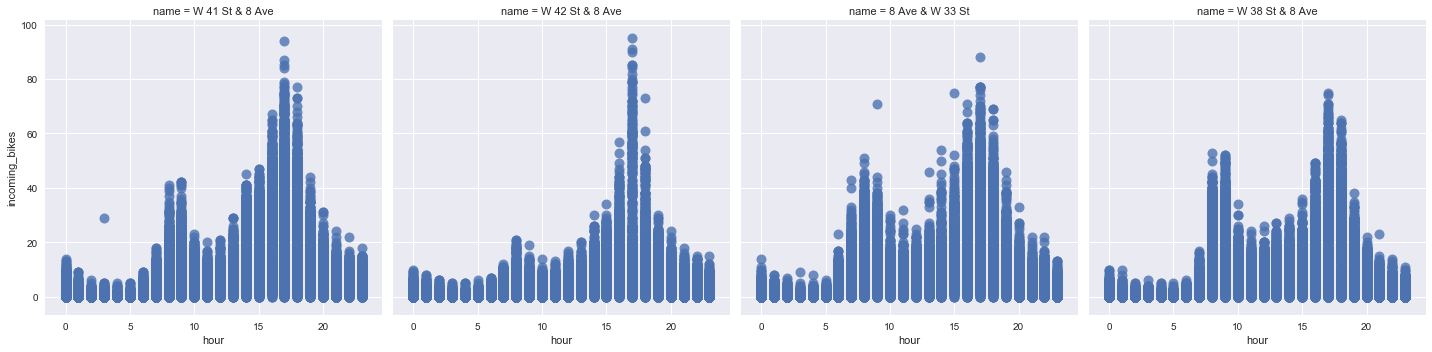

In [258]:
sns.lmplot('hour', # Horizontal axis
           'incoming_bikes', # Vertical axis
           data=all_df, # Data source
           fit_reg=False, # Don't fix a regression line
           col="name", # Set color
           scatter_kws={"marker": "D", # Set marker style
                        "s": 100}) # S marker size

** Station Outgoing Bikes by hour **

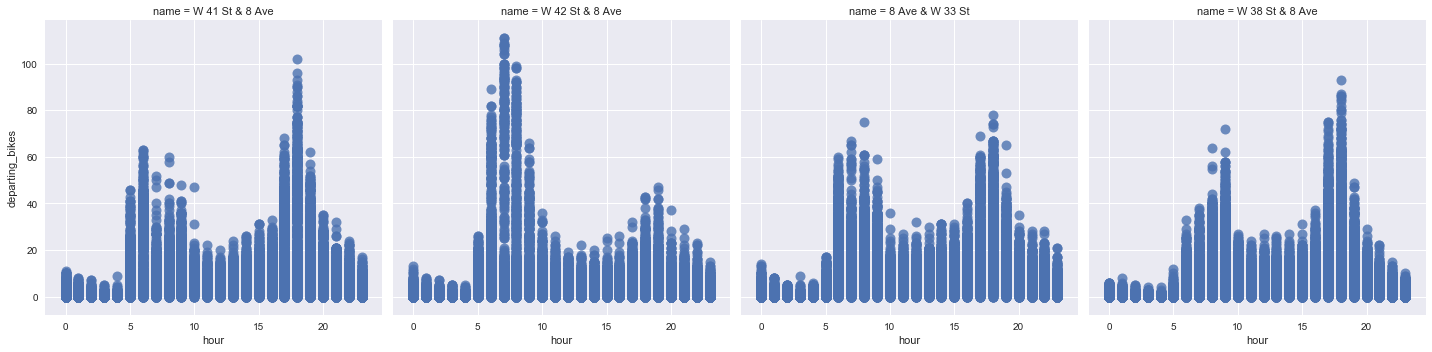

In [78]:
sns.lmplot('hour', # Horizontal axis
           'departing_bikes', # Vertical axis
           data=all_df, # Data source
           fit_reg=False, # Don't fix a regression line
           col="name", # Set color
           scatter_kws={"marker": "D", # Set marker style
                        "s": 100}) # S marker size

** Station Flow by hour **

In [256]:
sns.set_style('darkgrid', {'legend.frameon':True})


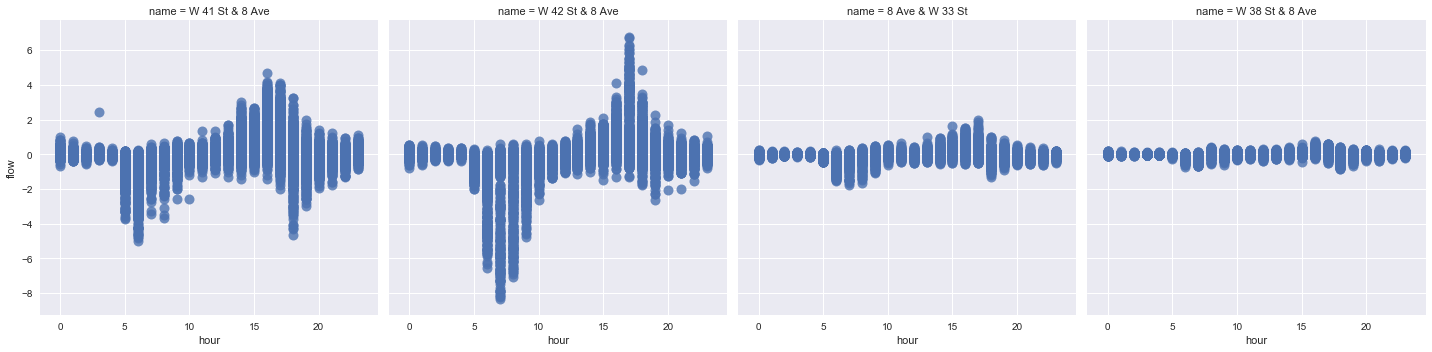

In [257]:
sns.lmplot('hour', # Horizontal axis
           'flow', # Vertical axis
           data=all_df, # Data source
           fit_reg=False, # Don't fix a regression line
           col="name", # Set color
           scatter_kws={"marker": "D", # Set marker style
                        "s": 100}) # S marker size
    


** Station Flow by day of week **

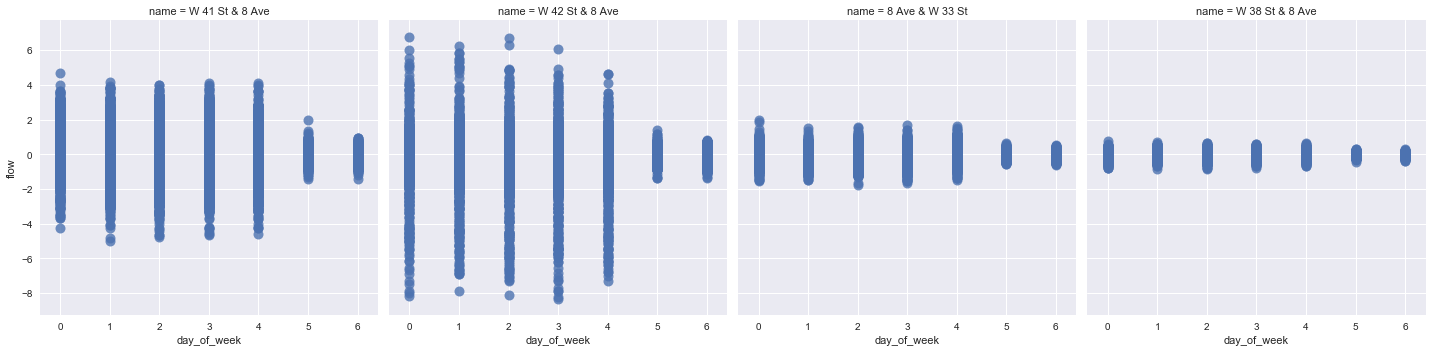

In [81]:
sns.lmplot('day_of_week', # Horizontal axis
           'flow', # Vertical axis
           data=all_df, # Data source
           fit_reg=False, # Don't fix a regression line
           col="name", # Set color
           scatter_kws={"marker": "D", # Set marker style
                        "s": 100}) # S marker size

Notes:
 Except for weekday vs weekend, doesn't look too useful   

In [83]:
all_df=all_df[['year','month','week','day_of_week','hour','station_id','temp','prcp','is_foggy','is_raining','is_snowing','flow'
              ,'num_docks_available'
              ]]

In [84]:
len(all_df)

79189

In [85]:
all_df.head()

,year,month,week,day_of_week,hour,station_id,temp,prcp,is_foggy,is_raining,is_snowing,flow,num_docks_available
0,2015,7,29,1,5,477,76.1,0.0,1,1,0,-1.833333,12
1,2015,7,29,1,6,477,76.1,0.0,1,1,0,-3.500000,12
2,2015,7,29,1,17,477,76.1,0.0,1,1,0,1.916667,12
3,2015,7,29,1,18,477,76.1,0.0,1,1,0,-0.583333,12
4,2015,7,29,1,19,477,76.1,0.0,1,1,0,-0.333333,12


** Correlation **

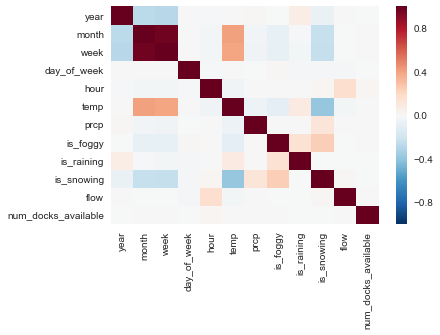

In [87]:
sns.heatmap(all_df.corr())

Notes:    
only hour has a correlation between flow

In [ ]:
all_df.columns

# Model exploration

In [92]:
def train_test_rmse(df,features_cols,target_col):
    X=df[features_cols]
    y=df[target_col]
    #X_train, X_test,y_train, y_test = train_test_split(X,y)
    #clf = svm.SVR()
    #clf = ElasticNet(random_state=0)
    clf = LinearRegression()
    #clf = RandomForestRegressor( random_state=0,)
    
    
    
    scores = cross_val_score(clf, X, y, cv=5,scoring='r2')
    #print(clf.coef_) 
    #print(clf.feature_importances_)
    return scores
    #return np.sqrt(scores) 

    
    #clf.fit(X_train,y_train)
    #y_pred=clf.predict(X_test)
    #return np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    #return scores

In [93]:
all_df.head()

,year,month,week,day_of_week,hour,station_id,temp,prcp,is_foggy,is_raining,is_snowing,flow,num_docks_available
0,2015,7,29,1,5,477,76.1,0.0,1,1,0,-1.833333,12
1,2015,7,29,1,6,477,76.1,0.0,1,1,0,-3.500000,12
2,2015,7,29,1,17,477,76.1,0.0,1,1,0,1.916667,12
3,2015,7,29,1,18,477,76.1,0.0,1,1,0,-0.583333,12
4,2015,7,29,1,19,477,76.1,0.0,1,1,0,-0.333333,12


In [226]:
def get_text_cols(df):
    return df[['year','month','hour', 'week','day_of_week','station_id','is_foggy','is_raining','is_snowing']]

def get_numeric_cols(df):
    return df[['temp','prcp']]



In [227]:
all_df.columns

Index(['year', 'month', 'week', 'day_of_week', 'hour', 'station_id', 'temp',
       'prcp', 'is_foggy', 'is_raining', 'is_snowing', 'flow',
       'num_docks_available'],
      dtype='object')

In [228]:
features_cols = [ 'year','month', 'week', 'hour', 'station_id', 'temp', 'prcp', 'is_foggy',
       'is_raining', 'is_snowing', 'num_docks_available']

** ML Pipeline **      
Hot encode all categorical features    
Scale numeric features     
Use Lasso to identify good features
Build Linear Regression

In [229]:
cat_cols = ['year','month','hour', 'week','station_id','is_foggy','is_raining','is_snowing']
#cat_cols = ['hour', 'week','station_id']
category_pipeline =   make_pipeline (ce.OneHotEncoder(cols =cat_cols ))
numerical_pipleine = make_pipeline(FunctionTransformer(get_numeric_cols, validate=False), 
                                MinMaxScaler())
features_pipeline = FeatureUnion([('categorical', category_pipeline), ('numerical', numerical_pipleine)])

ml_pipeline = Pipeline([('features', features_pipeline)
         ,('best_features',SelectFromModel(LassoCV()))
        , ('clf', LinearRegression()  )        
         
         ] )

## Best Features

In [230]:
X_train, X_test, y_train, y_test = train_test_split(
...     all_df[features_cols], all_df['flow'], random_state=0)

ml_pipeline.fit(X_train,y_train)


Pipeline(steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('categorical', Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=['year', 'month', 'hour', 'week', 'station_id', 'is_foggy', 'is_raining', 'is_snowing'],
       drop_invariant=False, handle_unknown='impute', impute_missing=True,...shold=None)), ('clf', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [231]:
transformed_cols  = list(category_pipeline.transform(X_train).columns) + list(get_numeric_cols(X_train).columns)

feature_importances = pd.DataFrame({'features':transformed_cols
                                    ,'support': ml_pipeline.named_steps['best_features'].get_support()
                                    ,'coef': ml_pipeline.named_steps['best_features'].estimator_.coef_
                                   })
feature_importances['magnitude'] = feature_importances['coef'].apply(abs)
feature_importances =feature_importances.sort_values(['support','magnitude'],ascending=False)
feature_importances.head(20)

,coef,features,support,magnitude
30,-0.791189,hour_13,True,0.791189
31,0.602192,hour_14,True,0.602192
18,0.456551,hour_1,True,0.456551
37,-0.427334,hour_20,True,0.427334
20,0.371778,hour_3,True,0.371778
35,-0.296585,hour_18,True,0.296585
21,0.272211,hour_4,True,0.272211
32,-0.200777,hour_15,True,0.200777
26,-0.113800,hour_9,True,0.113800
33,0.071663,hour_16,True,0.071663


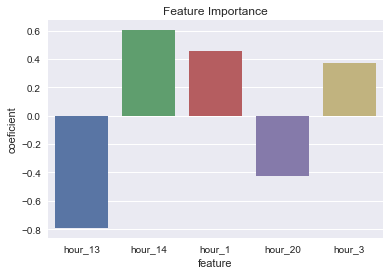

In [266]:
t_df = feature_importances
sns.barplot(x="features", y="coef", data=feature_importances.head(5))
plt.xlabel('feature')
plt.ylabel('coeficient')
plt.title('Feature Importance')

**Notes** :
Only hour is the best feature :(    
1pm and 8pm sees a negative flow (people are leaving)

In [232]:
scores = cross_val_score(ml_pipeline, X_train, y_train, cv=5,scoring='r2')
scores

array([ 0.19843788,  0.21287809,  0.20030677,  0.21509816,  0.20351816])

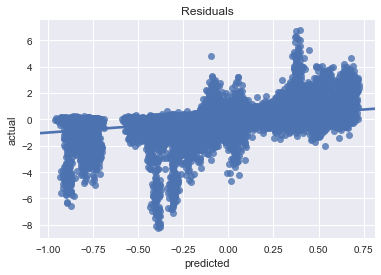

In [282]:
test_predictions = pd.DataFrame({'actual':y_test , 'predicted':ml_pipeline.predict(X_test) , 'station_id':X_test['station_id']})
sns_plot=sns.regplot(x =ml_pipeline.predict(X_train) , y = y_train )
plt.title("Residuals")
plt.xlabel('predicted')
plt.ylabel('actual')
sns_plot.figure.savefig("residuals.png")
sns_plot

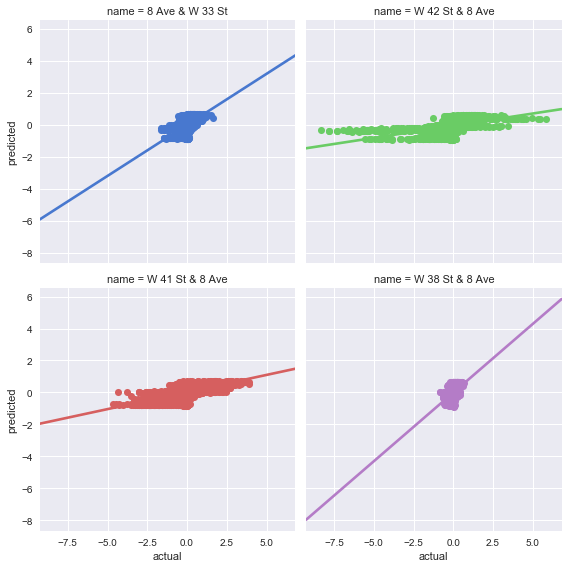

In [281]:
sns.lmplot(x="actual", y="predicted", col="name", hue="name", data=pd.merge(test_predictions,nearby_stations,on='station_id'),
           col_wrap=2, ci=None, palette="muted", size=4,
           scatter_kws={"s": 50, "alpha": 1})

# Much Simpler Model    
Train a model without weather 

In [244]:
features_cols = ['year','month','hour', 'week','day_of_week','station_id'] # date , stationid
X_train, X_test, y_train, y_test = train_test_split(
    all_df[features_cols], all_df['flow'], random_state=0)

cat_cols = features_cols
category_pipeline =   make_pipeline (ce.OneHotEncoder(cols =cat_cols ))


ml_pipeline = Pipeline([('features', category_pipeline)
         ,('best_features',SelectFromModel(LassoCV()))
        , ('clf', LinearRegression()  )   
         
         ] )

In [245]:
ml_pipeline.fit(X_train,y_train)
cross_val_score(ml_pipeline, X_train, y_train, cv=5,scoring='r2')


array([ 0.19928383,  0.2134189 ,  0.20090374,  0.21570498,  0.20381459])

In [247]:
s ={'year':2016 , 'month':4,'week':15,'hour':22 ,'station_id':490 ,'day_of_week':5 }
#s = X_test.head(1).to_dict(orient='records')

In [248]:
ml_pipeline.predict(pd.DataFrame.from_dict(s)[features_cols])

array([ 0.01064987])

# Save model


In [241]:
from sklearn.externals import joblib

In [242]:
!pwd

/Users/nidhin/Desktop/Data/2017/ableto/citibike/my_code


In [243]:
joblib.dump(ml_pipeline,'../gcp/data/model.pkl')
joblib.dump(features_cols,'../gcp/data/cols.pkl')

['../gcp/data/cols.pkl']